In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths - these are the files from the IDSpyder system
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/Idspyder-21.08.11.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/Idspyder-21.08.13.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/Idspyder-21.12.13.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/Idspyder-21.12.20.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/Idspyder-21.11.11.csv']

In [3]:
#check where event data starts
data_RFID_int = pd.read_csv(RFID_data_dir_paths[4], sep=';', encoding='utf-16')
data_RFID_int = pd.DataFrame(data = data_RFID_int)

data_RFID_int.head(75)#.iloc[33: , :].head()

,DateTime,IdRFID,IdLabel,unitLabel,eventDuration,sense1duration,sense1Events,senseRFIDrecords,outFuncLabel,outLabel,SystemMsg,MsgValue1,MsgValue2,MsgValue3
0,#ID-Device,Spyder1.1,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#ID-Device,Spyder1.2,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#ID-Device,Spyder1.3,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#ID-Device,Spyder1.4,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#ID-Device,Spyder1.5,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,#ID-Device,Spyder1.6,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,#ID-Device,Spyder1.7,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,#ID-Device,Spyder1.8,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,#ID-Device,Spyder1.9,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,#ID-Device,Spyder1.10,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean df and combine into 1

In [7]:
row_drop = 33 #row event data starts

data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths[3:4]:
    print(path)

    if path.split('/')[-1] == '.DS_Store':
        continue
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.iloc[row_drop: , :]
    print(data_RFID_int.shape)
    
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    
    #add file name
    data_RFID_int['RFID_file'] = path.split('/')[-1]
    
    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2021) - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute
    data_RFID_int['RFID_second'] = data_RFID_int['RFID_datetime_start'].dt.second

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['RFID_file', 'IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]

print(data_RFID.shape,'\n')

data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/RFID/flavor/Idspyder-21.12.13.csv
(206859, 14)
(206858, 23) 

(206858, 11) 



,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
33,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40
34,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49
35,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51
36,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2
37,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53


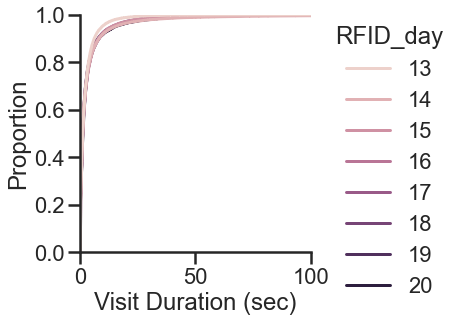

In [8]:
sns.displot(data=data_RFID, x="eventDuration", kind="ecdf", hue='RFID_day')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 100)
plt.show()

In [6]:
data_RFID['RFID_day'].value_counts()

21    40556
22    35808
20    20221
23    12989
Name: RFID_day, dtype: int64

In [7]:
data_RFID['IdRFID'].value_counts()

041AC00422    9319
041AC02849    7789
041ABFE878    7654
041AC00EFA    6377
041ABFE8D0    6291
041AC038C9    6187
041AC03717    5839
041AC00095    5686
041ABFF7C1    5409
041AC006F3    5265
041ABFE8D4    5225
041AC033A1    5051
041AC00A9F    4305
041AC028F2    4166
041AC02E92    3765
041AC00F03    3668
041ABFF5CF    2928
041ABFF7BD    2502
041ABFEC1B    2497
041AC00425    2443
041AC009ED    2243
041ABFF18E    2077
041AC0041B    1805
041AC03A4B    1083
Name: IdRFID, dtype: int64

#### Compute endtime 

In [8]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(109574, 13)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
33,Idspyder-21.12.20.csv,041AC02849,Spyder2.28,0.075,2021-12-20 12:57:14.011977600,2021-12-20,20,12:57:14,12,57,14,2021-12-20 12:57:14.086977600,12:57:14
34,Idspyder-21.12.20.csv,041ABFE8D4,Spyder1.10,0.075,2021-12-20 12:57:15.824044800,2021-12-20,20,12:57:15,12,57,15,2021-12-20 12:57:15.899044800,12:57:15
35,Idspyder-21.12.20.csv,041AC028F2,Spyder2.24,3.218,2021-12-20 12:57:13.701974400,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:16.919974400,12:57:16
36,Idspyder-21.12.20.csv,041AC02E92,Spyder1.7,3.457,2021-12-20 12:57:13.971974399,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:17.428974399,12:57:17
37,Idspyder-21.12.20.csv,041AC00A9F,Spyder1.11,0.628,2021-12-20 12:57:17.471001600,2021-12-20,20,12:57:17,12,57,17,2021-12-20 12:57:18.099001600,12:57:18


#### Add day, hour, and min counts

In [9]:
#column of running day count
dat_map = dict(zip(data_RFID['RFID_date'].unique(), np.arange(1,len(data_RFID['RFID_date'].unique())+1)))
data_RFID['RFID_day_count'] = data_RFID['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID['RFID_min_count'] = (data_RFID['RFID_hour']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count'] = (data_RFID['RFID_min_count']*60) + data_RFID['RFID_second'] 

#column of running hour and minute count across all days
data_RFID['RFID_hour_count_running'] = (data_RFID['RFID_day_count']*24) + data_RFID['RFID_hour'] - 24
data_RFID['RFID_min_count_running'] = (data_RFID['RFID_hour_count_running']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count_running'] = (data_RFID['RFID_min_count_running']*60) + data_RFID['RFID_second'] - 60

print(data_RFID.shape)
data_RFID.head()

(109574, 19)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
33,Idspyder-21.12.20.csv,041AC02849,Spyder2.28,0.075,2021-12-20 12:57:14.011977600,2021-12-20,20,12:57:14,12,57,14,2021-12-20 12:57:14.086977600,12:57:14,1,777,46634,12,777,46574
34,Idspyder-21.12.20.csv,041ABFE8D4,Spyder1.10,0.075,2021-12-20 12:57:15.824044800,2021-12-20,20,12:57:15,12,57,15,2021-12-20 12:57:15.899044800,12:57:15,1,777,46635,12,777,46575
35,Idspyder-21.12.20.csv,041AC028F2,Spyder2.24,3.218,2021-12-20 12:57:13.701974400,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:16.919974400,12:57:16,1,777,46633,12,777,46573
36,Idspyder-21.12.20.csv,041AC02E92,Spyder1.7,3.457,2021-12-20 12:57:13.971974399,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:17.428974399,12:57:17,1,777,46633,12,777,46573
37,Idspyder-21.12.20.csv,041AC00A9F,Spyder1.11,0.628,2021-12-20 12:57:17.471001600,2021-12-20,20,12:57:17,12,57,17,2021-12-20 12:57:18.099001600,12:57:18,1,777,46637,12,777,46577


In [10]:
dat_map

{datetime.date(2021, 12, 20): 1,
 datetime.date(2021, 12, 21): 2,
 datetime.date(2021, 12, 22): 3,
 datetime.date(2021, 12, 23): 4}

#### Add light dark

In [11]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID['ld_seg'] = data_RFID['RFID_hour'].apply(assign_ld)

print(data_RFID.shape)
data_RFID.head()


(109574, 20)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
33,Idspyder-21.12.20.csv,041AC02849,Spyder2.28,0.075,2021-12-20 12:57:14.011977600,2021-12-20,20,12:57:14,12,57,14,2021-12-20 12:57:14.086977600,12:57:14,1,777,46634,12,777,46574,light
34,Idspyder-21.12.20.csv,041ABFE8D4,Spyder1.10,0.075,2021-12-20 12:57:15.824044800,2021-12-20,20,12:57:15,12,57,15,2021-12-20 12:57:15.899044800,12:57:15,1,777,46635,12,777,46575,light
35,Idspyder-21.12.20.csv,041AC028F2,Spyder2.24,3.218,2021-12-20 12:57:13.701974400,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:16.919974400,12:57:16,1,777,46633,12,777,46573,light
36,Idspyder-21.12.20.csv,041AC02E92,Spyder1.7,3.457,2021-12-20 12:57:13.971974399,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:17.428974399,12:57:17,1,777,46633,12,777,46573,light
37,Idspyder-21.12.20.csv,041AC00A9F,Spyder1.11,0.628,2021-12-20 12:57:17.471001600,2021-12-20,20,12:57:17,12,57,17,2021-12-20 12:57:18.099001600,12:57:18,1,777,46637,12,777,46577,light


#### Add day/night mapping (lines up dates and ld segments)

In [12]:
ld_mapping_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(89, 4)


,day,ld_seg,ld_cycle,ld_day
0,1,light,light,light_day1
1,1,dark_pm,dark,dark_night1
2,2,light,light,light_day2
3,2,dark_pm,dark,dark_night2
4,2,dark_am,dark,dark_night1


In [13]:
data_RFID = data_RFID.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID.shape)
data_RFID.head()

(109574, 23)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day
0,Idspyder-21.12.20.csv,041AC02849,Spyder2.28,0.075,2021-12-20 12:57:14.011977600,2021-12-20,20,12:57:14,12,57,14,2021-12-20 12:57:14.086977600,12:57:14,1,777,46634,12,777,46574,light,1,light,light_day1
1,Idspyder-21.12.20.csv,041ABFE8D4,Spyder1.10,0.075,2021-12-20 12:57:15.824044800,2021-12-20,20,12:57:15,12,57,15,2021-12-20 12:57:15.899044800,12:57:15,1,777,46635,12,777,46575,light,1,light,light_day1
2,Idspyder-21.12.20.csv,041AC028F2,Spyder2.24,3.218,2021-12-20 12:57:13.701974400,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:16.919974400,12:57:16,1,777,46633,12,777,46573,light,1,light,light_day1
3,Idspyder-21.12.20.csv,041AC02E92,Spyder1.7,3.457,2021-12-20 12:57:13.971974399,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:17.428974399,12:57:17,1,777,46633,12,777,46573,light,1,light,light_day1
4,Idspyder-21.12.20.csv,041AC00A9F,Spyder1.11,0.628,2021-12-20 12:57:17.471001600,2021-12-20,20,12:57:17,12,57,17,2021-12-20 12:57:18.099001600,12:57:18,1,777,46637,12,777,46577,light,1,light,light_day1


In [16]:
data_RFID.groupby(['unitLabel'])['IdRFID'].value_counts()

unitLabel   IdRFID    
Spyder1.1   041ABFF7BD    789 
            041AC00425    677 
            041AC0041B    529 
Spyder1.10  041AC03717    1352
            041AC00A9F    1181
            041ABFE8D4    965 
Spyder1.11  041AC03717    1327
            041ABFE8D4    1116
            041AC00A9F    978 
Spyder1.12  041AC03717    1755
            041ABFE8D4    1226
            041AC00A9F    920 
Spyder1.13  041ABFE8D0    1363
            041ABFE878    817 
            041AC00095    680 
Spyder1.14  041ABFE8D0    1365
            041ABFE878    829 
            041AC00095    741 
Spyder1.15  041ABFE878    1732
            041ABFE8D0    1708
            041AC00095    1426
Spyder1.16  041ABFE878    4275
            041AC00095    2838
            041ABFE8D0    1854
Spyder1.2   041AC00425    711 
            041ABFF7BD    596 
            041AC0041B    505 
Spyder1.3   041ABFF7BD    475 
            041AC00425    458 
            041AC0041B    384 
Spyder1.4   041ABFF7BD    642 
            041A

#### Map unitLabel and bottle contents

In [17]:
RFID_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/prev/bottle_assignment_RFID.xlsx'

RFID_bottle_assignment = pd.read_excel(RFID_bottle_assignment_path)
RFID_bottle_assignment = pd.DataFrame(data = RFID_bottle_assignment)
print(RFID_bottle_assignment.shape)
RFID_bottle_assignment.head()

(10, 35)


,cohort,RFID_file,VDM_file,Spyder1.1,Spyder1.2,Spyder1.3,Spyder1.4,Spyder1.5,Spyder1.6,Spyder1.7,Spyder1.8,Spyder1.9,Spyder1.10,Spyder1.11,Spyder1.12,Spyder1.13,Spyder1.14,Spyder1.15,Spyder1.16,Spyder2.17,Spyder2.18,Spyder2.19,Spyder2.20,Spyder2.21,Spyder2.22,Spyder2.23,Spyder2.24,Spyder2.25,Spyder2.26,Spyder2.27,Spyder2.28,Spyder2.29,Spyder2.30,Spyder2.31,Spyder2.32
0,flavor,Idspyder-21.11.11.csv,br.c.g.o_fm_211111.csv,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,flavor,Idspyder-21.12.13.csv,c.br.o.g_fm_211213.csv,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape
2,flavor,Idspyder-21.12.20.csv,br.c.g.o_switchfm_211220.csv,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange,blue_ras,cherry,grape,orange
3,plain_etoh,Idspyder-22.01.05.csv,5.10.20.h20_fm_220105.csv,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water
4,plain_etoh,Idspyder-22.01.19.csv,5.10.20.h20_m_220119.csv,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water,etoh_05,etoh_10,etoh_20,water


In [18]:
file=data_RFID['RFID_file'].unique()[0]
RFID_bottle_map = RFID_bottle_assignment[RFID_bottle_assignment['RFID_file']==file].reset_index().loc[0,'Spyder1.1':'Spyder2.32'].to_dict()

data_RFID['unitLabel_drink'] = data_RFID['unitLabel'].map(RFID_bottle_map)
print(data_RFID.shape)

data_RFID.head()

(109574, 24)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,unitLabel_drink
0,Idspyder-21.12.20.csv,041AC02849,Spyder2.28,0.075,2021-12-20 12:57:14.011977600,2021-12-20,20,12:57:14,12,57,14,2021-12-20 12:57:14.086977600,12:57:14,1,777,46634,12,777,46574,light,1,light,light_day1,orange
1,Idspyder-21.12.20.csv,041ABFE8D4,Spyder1.10,0.075,2021-12-20 12:57:15.824044800,2021-12-20,20,12:57:15,12,57,15,2021-12-20 12:57:15.899044800,12:57:15,1,777,46635,12,777,46575,light,1,light,light_day1,cherry
2,Idspyder-21.12.20.csv,041AC028F2,Spyder2.24,3.218,2021-12-20 12:57:13.701974400,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:16.919974400,12:57:16,1,777,46633,12,777,46573,light,1,light,light_day1,orange
3,Idspyder-21.12.20.csv,041AC02E92,Spyder1.7,3.457,2021-12-20 12:57:13.971974399,2021-12-20,20,12:57:13,12,57,13,2021-12-20 12:57:17.428974399,12:57:17,1,777,46633,12,777,46573,light,1,light,light_day1,grape
4,Idspyder-21.12.20.csv,041AC00A9F,Spyder1.11,0.628,2021-12-20 12:57:17.471001600,2021-12-20,20,12:57:17,12,57,17,2021-12-20 12:57:18.099001600,12:57:18,1,777,46637,12,777,46577,light,1,light,light_day1,grape


In [19]:
data_RFID.groupby('unitLabel_drink')['unitLabel'].value_counts()

unitLabel_drink  unitLabel 
blue_ras         Spyder2.25    6529
                 Spyder1.9     4546
                 Spyder2.17    3714
                 Spyder1.5     3122
                 Spyder1.13    2860
                 Spyder2.21    2371
                 Spyder1.1     1995
                 Spyder2.29    1485
cherry           Spyder2.18    5575
                 Spyder2.26    3997
                 Spyder1.10    3498
                 Spyder1.14    2935
                 Spyder2.22    2556
                 Spyder1.6     2083
                 Spyder1.2     1812
                 Spyder2.30    1405
grape            Spyder2.23    5231
                 Spyder1.15    4866
                 Spyder2.19    4541
                 Spyder2.27    3616
                 Spyder1.11    3421
                 Spyder1.7     2197
                 Spyder2.31    1341
                 Spyder1.3     1317
orange           Spyder1.16    8967
                 Spyder2.20    7272
                 Spyder2.24    4352


#### Add metadata and clean

In [13]:
meta_data.head()

,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes
0,flavor,four_four,21.08.11,na,1,041A5554E6,NaN,NaN,na,male,3,33.0,NaN,NaN,NaN
1,flavor,four_four,21.08.11,na,1,041A555DA1,NaN,NaN,na,male,3,33.0,NaN,NaN,NaN
2,flavor,four_four,21.08.11,na,1,041A555DEB,NaN,NaN,na,male,3,33.0,NaN,NaN,NaN
3,flavor,four_four,21.08.11,na,2,041A555A4C,NaN,NaN,na,male,3,33.0,NaN,NaN,NaN
4,flavor,four_four,21.08.11,na,2,041A555C38,NaN,NaN,na,male,3,33.0,NaN,NaN,NaN


In [12]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/meta_data.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(206858, 26)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,RFID_file,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
0,flavor,four_eight,21.12.20,na,2,041ABFF5CF,1616.0,467.0,na,male,3,29.5,NaN,NaN,NaN,41,Idspyder-21.12.13.csv,Spyder1.8,0.076,2021-12-13 16:17:54.701030400,2021-12-13,13,16:17:54,16,17,54
1,flavor,four_eight,21.12.20,na,2,041ABFF5CF,1616.0,467.0,na,male,3,29.5,NaN,NaN,NaN,43,Idspyder-21.12.13.csv,Spyder1.8,0.314,2021-12-13 16:17:57.356016000,2021-12-13,13,16:17:57,16,17,57
2,flavor,four_eight,21.12.20,na,2,041ABFF5CF,1616.0,467.0,na,male,3,29.5,NaN,NaN,NaN,53,Idspyder-21.12.13.csv,Spyder1.5,0.558,2021-12-13 16:18:58.951958400,2021-12-13,13,16:18:58,16,18,58
3,flavor,four_eight,21.12.20,na,2,041ABFF5CF,1616.0,467.0,na,male,3,29.5,NaN,NaN,NaN,54,Idspyder-21.12.13.csv,Spyder1.5,0.073,2021-12-13 16:19:00.823987200,2021-12-13,13,16:19:00,16,19,0
4,flavor,four_eight,21.12.20,na,2,041ABFF5CF,1616.0,467.0,na,male,3,29.5,NaN,NaN,NaN,55,Idspyder-21.12.13.csv,Spyder1.5,0.075,2021-12-13 16:19:03.210960000,2021-12-13,13,16:19:03,16,19,3


In [21]:
data_RFID_final = data_RFID_final[['Round', 'Build', 'Timepoint', 'Cage', 'IdRFID', 'Animal', 'Injury', 'Sex', 'Cage_N', 
                                   'unitLabel_drink', 'unitLabel', 'eventDuration',
                                   'ld_cycle', 'ld_day', 'day', 'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_datetime_start', 'RFID_datetime_end', 'RFID_time_start', 'RFID_time_end', 
                                   'RFID_min_count', 'RFID_sec_count', 
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running', 
                                   'RFID_file', 'weight_pre', 'weight_post', 'weight_diff', 'notes',]]

print(data_RFID_final.shape)
data_RFID_final.head()

(109574, 32)


,Round,Build,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
0,flavor,four_eight,na,1,041AC00425,1612.0,na,male,3,cherry,Spyder1.2,0.598,light,light_day1,1,12,57,20,2021-12-20 12:57:20.294985600,2021-12-20 12:57:20.892985600,12:57:20,12:57:20,777,46640,12,777,46580,Idspyder-21.12.20.csv,32.9,NaN,NaN,NaN
1,flavor,four_eight,na,1,041AC00425,1612.0,na,male,3,cherry,Spyder1.2,0.767,light,light_day1,1,12,57,22,2021-12-20 12:57:22.893984000,2021-12-20 12:57:23.660984000,12:57:22,12:57:23,777,46642,12,777,46582,Idspyder-21.12.20.csv,32.9,NaN,NaN,NaN
2,flavor,four_eight,na,1,041AC00425,1612.0,na,male,3,cherry,Spyder1.2,0.666,light,light_day1,1,12,57,26,2021-12-20 12:57:26.109964800,2021-12-20 12:57:26.775964800,12:57:26,12:57:26,777,46646,12,777,46586,Idspyder-21.12.20.csv,32.9,NaN,NaN,NaN
3,flavor,four_eight,na,1,041AC00425,1612.0,na,male,3,cherry,Spyder1.2,0.075,light,light_day1,1,12,57,32,2021-12-20 12:57:32.441011200,2021-12-20 12:57:32.516011200,12:57:32,12:57:32,777,46652,12,777,46592,Idspyder-21.12.20.csv,32.9,NaN,NaN,NaN
4,flavor,four_eight,na,1,041AC00425,1612.0,na,male,3,cherry,Spyder1.2,0.253,light,light_day1,1,12,57,35,2021-12-20 12:57:35.465011200,2021-12-20 12:57:35.718011200,12:57:35,12:57:35,777,46655,12,777,46595,Idspyder-21.12.20.csv,32.9,NaN,NaN,NaN


In [22]:
data_RFID_final.groupby('Sex')['Cage'].value_counts()

Sex     Cage
female  5       21105
        4       19631
        3       15369
        6       14482
male    7       17644
        2       8770 
        1       6750 
        8       5823 
Name: Cage, dtype: int64

In [23]:
data_RFID_final.to_csv('RFID_211220.csv')

#### Viz

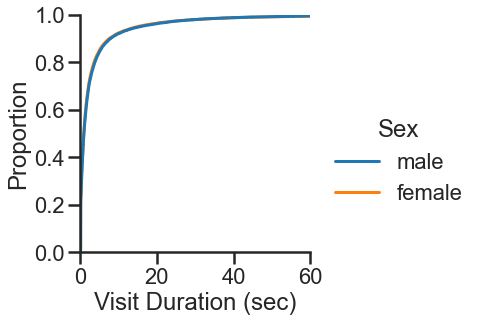

In [24]:
data_int = data_RFID_final
sns.displot(data=data_int, x="eventDuration", kind="ecdf", hue='Sex')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

<Figure size 720x360 with 0 Axes>

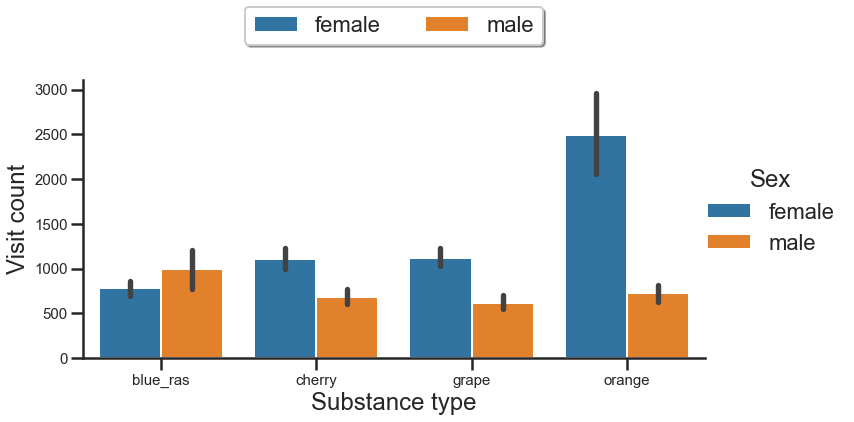

In [25]:
data_int = data_RFID_final

data_int = data_int.groupby(['Sex', 'IdRFID', 'Cage_N', 'day', 'unitLabel_drink'])['eventDuration'].sum().reset_index(name='count')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="unitLabel_drink", y='count', hue="Sex", kind='bar', height=5, aspect=2, ci=68,)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), 
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### VDM data

#### Make and clean df

In [26]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor'
    
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/c.br.o.g_fm_211213.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/br.c.g.o_switchfm_211220.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/br.c.g.o_fm_211111.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/c.o.br.g_mfc2_210811.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/g.go.o.w_mfc2_210813.csv']

In [27]:
data_VDM_int = pd.read_table(VDM_data_dir_paths[2], sep=';')
data_VDM_int = pd.DataFrame(data = data_VDM_int)
data_VDM_int.head(50)

,Columbus Instruments Device Interface Version 1.5
0,"Started On:,12/20/21 12:58:12"
1,[Experiment Setup Info]
2,"Program Path:,C:\Program Files (x86)\CI Multi-Device Interface"
3,"Data Path:,C:\Program Files (x86)\CI Multi-Device Interface\Data"
4,"Experiment File Name:,C:\Users\PhenoUser\Documents\VDM\final_setup\br.c.g.o_switchfm_211220.csv"
5,"Session Interval:,00:00:01"
6,"Experiment Duration:,0"
7,"Staggered Start Enable:,False"
8,[Channel Setup Info]
9,"Cage 1,Cage1"


In [28]:
row_drop = 22
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths[2:3]:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_VDM_int = pd.read_table(path, sep=';')
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    data_VDM_int = data_VDM_int.iloc[row_drop: , :]['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
    data_VDM_int.columns = data_VDM_int.loc[row_drop].values
    data_VDM_int = data_VDM_int.drop(row_drop)
    
    data_VDM_int['VDM_file'] = path.split('/')[-1]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')

print(data_VDM.shape)
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/data/VDM/flavor/br.c.g.o_switchfm_211220.csv
(1238743, 13) 

(1238743, 13)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,VDM_file
23,0,1,12/20/21 12:58:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,br.c.g.o_switchfm_211220.csv
24,0,2,12/20/21 12:58:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,br.c.g.o_switchfm_211220.csv
25,0,3,12/20/21 12:58:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,br.c.g.o_switchfm_211220.csv
26,0,4,12/20/21 12:58:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,br.c.g.o_switchfm_211220.csv
27,0,5,12/20/21 12:58:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,br.c.g.o_switchfm_211220.csv


In [29]:
data_VDM.columns

Index(['Int', 'Cage', 'Time', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', '', 'VDM_file'], dtype='object')

#### Clean up column names

In [30]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 'drink_1_accum',
                    'drink_2', 'drink_2_accum',
                    'drink_3', 'drink_3_accum',
                    'drink_4', 'drink_4_accum',
                    'blank', 'VDM_file']

data_VDM = data_VDM[['VDM_file', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 
                    'drink_2', 
                    'drink_3', 
                    'drink_4', 
                    ]]

data_VDM.tail()

,VDM_file,Cage_VDM,VDM_Time,drink_1,drink_2,drink_3,drink_4
1238761,br.c.g.o_switchfm_211220.csv,4,12/23/21 09:27:21,0.000,0.000,0.000,0.000
1238762,br.c.g.o_switchfm_211220.csv,5,12/23/21 09:27:21,0.000,0.000,0.000,0.000
1238763,br.c.g.o_switchfm_211220.csv,6,12/23/21 09:27:21,0.000,0.000,0.000,0.000
1238764,br.c.g.o_switchfm_211220.csv,7,12/23/21 09:27:21,0.000,0.000,0.000,0.000
1238765,br.c.g.o_switchfm_211220.csv,8,12/23/21 09:27:21,0.000,0.000,0.000,0.000


#### Make into tidy df

In [31]:
#melt dataframe (new column of parameters)

meta_params = ['VDM_file', 'Cage_VDM', 'VDM_Time']
intake_params = ['drink_1', 'drink_2', 'drink_3', 'drink_4']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

data_VDM_tidy = data_VDM_tidy.replace({'':0.000})

data_VDM_tidy['value'] = data_VDM_tidy['value'].astype('float')

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(4954972, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
0,br.c.g.o_switchfm_211220.csv,1,12/20/21 12:58:16,drink_1,0.0
1,br.c.g.o_switchfm_211220.csv,2,12/20/21 12:58:16,drink_1,0.0
2,br.c.g.o_switchfm_211220.csv,3,12/20/21 12:58:16,drink_1,0.0
3,br.c.g.o_switchfm_211220.csv,4,12/20/21 12:58:16,drink_1,0.0
4,br.c.g.o_switchfm_211220.csv,5,12/20/21 12:58:16,drink_1,0.0


In [32]:
data_VDM_tidy['value'].unique()

array([0.   , 0.021, 0.042, 0.022, 0.024, 0.048, 0.063, 0.126, 0.12 ,
       0.072, 0.025, 0.05 , 0.044, 0.02 , 0.105, 0.04 , 0.054, 0.027])

#### Drop times with no intake data

In [33]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0.000]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(9074, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
21,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:19,drink_1,0.021
37,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:22,drink_1,0.021
301,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:59:15,drink_1,0.021
1044,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:43,drink_1,0.042
1076,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:49,drink_1,0.042


#### Clean up datetime

In [34]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(9074, 13)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
21,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:19,drink_1,0.021,2021-12-20 12:58:19,1.640005e+09,2021-12-20,20,12:58:19,12,58,19
37,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:22,drink_1,0.021,2021-12-20 12:58:22,1.640005e+09,2021-12-20,20,12:58:22,12,58,22
301,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:59:15,drink_1,0.021,2021-12-20 12:59:15,1.640005e+09,2021-12-20,20,12:59:15,12,59,15
1044,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:43,drink_1,0.042,2021-12-20 13:01:43,1.640005e+09,2021-12-20,20,13:01:43,13,1,43
1076,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:49,drink_1,0.042,2021-12-20 13:01:49,1.640005e+09,2021-12-20,20,13:01:49,13,1,49


In [35]:
data_VDM_tidy_intake['VDM_day'].value_counts()

21    3192
22    3126
20    1438
23    1318
Name: VDM_day, dtype: int64

#### Add light dark and clean

In [36]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
21,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:19,drink_1,0.021,2021-12-20 12:58:19,1.640005e+09,2021-12-20,20,12:58:19,12,58,19,light
37,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:22,drink_1,0.021,2021-12-20 12:58:22,1.640005e+09,2021-12-20,20,12:58:22,12,58,22,light
301,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:59:15,drink_1,0.021,2021-12-20 12:59:15,1.640005e+09,2021-12-20,20,12:59:15,12,59,15,light
1044,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:43,drink_1,0.042,2021-12-20 13:01:43,1.640005e+09,2021-12-20,20,13:01:43,13,1,43,light
1076,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:49,drink_1,0.042,2021-12-20 13:01:49,1.640005e+09,2021-12-20,20,13:01:49,13,1,49,light


#### Map bottle contents

In [37]:
VDM_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/bottle_assignment_VDM.xlsx'

VDM_bottle_assignment = pd.read_excel(VDM_bottle_assignment_path)
VDM_bottle_assignment = pd.DataFrame(data = VDM_bottle_assignment)
print(VDM_bottle_assignment.shape)
VDM_bottle_assignment.head(10)

(75, 7)


,cohort,VDM_file,Cage_VDM,drink_1,drink_2,drink_3,drink_4
0,flavor,c.o.br.g_mfc2_210811.csv,NaN,VDM_cherry,VDM_orange,VDM_blueras,VDM_grape
1,flavor,g.go.o.w_mfc2_210813.csv,NaN,VDM_grape,VDM_grange,VDM_orange,VDM_water
2,flavor,br.c.g.o_fm_211111.csv,NaN,VDM_blueras,VDM_cherry,VDM_grape,VDM_orange
3,flavor,c.br.o.g_fm_211213.csv,NaN,VDM_cherry,VDM_blueras,VDM_orange,VDM_grape
4,flavor,br.c.g.o_switchfm_211220.csv,NaN,VDM_cherry,VDM_blueras,VDM_orange,VDM_grape
5,etoh,5.10.20.h20_fm_220105.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_H2O
6,etoh,5.10.20.h20_m_220119.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_H2O
7,etoh,5.10.20.h20_f_220126.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_H2O
8,etoh,5.10.20.h20_m_220209.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_H2O
9,etoh,5.10.20.h20_m_220216.csv,NaN,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_H2O


In [38]:
file=data_VDM_tidy_intake['VDM_file'].unique()[0]
VDM_bottle_map = VDM_bottle_assignment[VDM_bottle_assignment['VDM_file']==file].reset_index().loc[0,'drink_1':'drink_4'].to_dict()

data_VDM_tidy_intake['VDM_drink'] = data_VDM_tidy_intake['variable'].map(VDM_bottle_map)
print(data_VDM_tidy_intake.shape)

data_VDM_tidy_intake.head()

(9074, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
21,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:19,drink_1,0.021,2021-12-20 12:58:19,1.640005e+09,2021-12-20,20,12:58:19,12,58,19,light,VDM_cherry
37,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:58:22,drink_1,0.021,2021-12-20 12:58:22,1.640005e+09,2021-12-20,20,12:58:22,12,58,22,light,VDM_cherry
301,br.c.g.o_switchfm_211220.csv,6,12/20/21 12:59:15,drink_1,0.021,2021-12-20 12:59:15,1.640005e+09,2021-12-20,20,12:59:15,12,59,15,light,VDM_cherry
1044,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:43,drink_1,0.042,2021-12-20 13:01:43,1.640005e+09,2021-12-20,20,13:01:43,13,1,43,light,VDM_cherry
1076,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:01:49,drink_1,0.042,2021-12-20 13:01:49,1.640005e+09,2021-12-20,20,13:01:49,13,1,49,light,VDM_cherry


In [39]:
data_VDM_tidy_intake['Cage_VDM'].value_counts()

2    2041
3    1188
4    1177
7    1023
8    959 
6    943 
1    875 
5    868 
Name: Cage_VDM, dtype: int64

No handles with labels found to put in legend.


<Figure size 720x360 with 0 Axes>

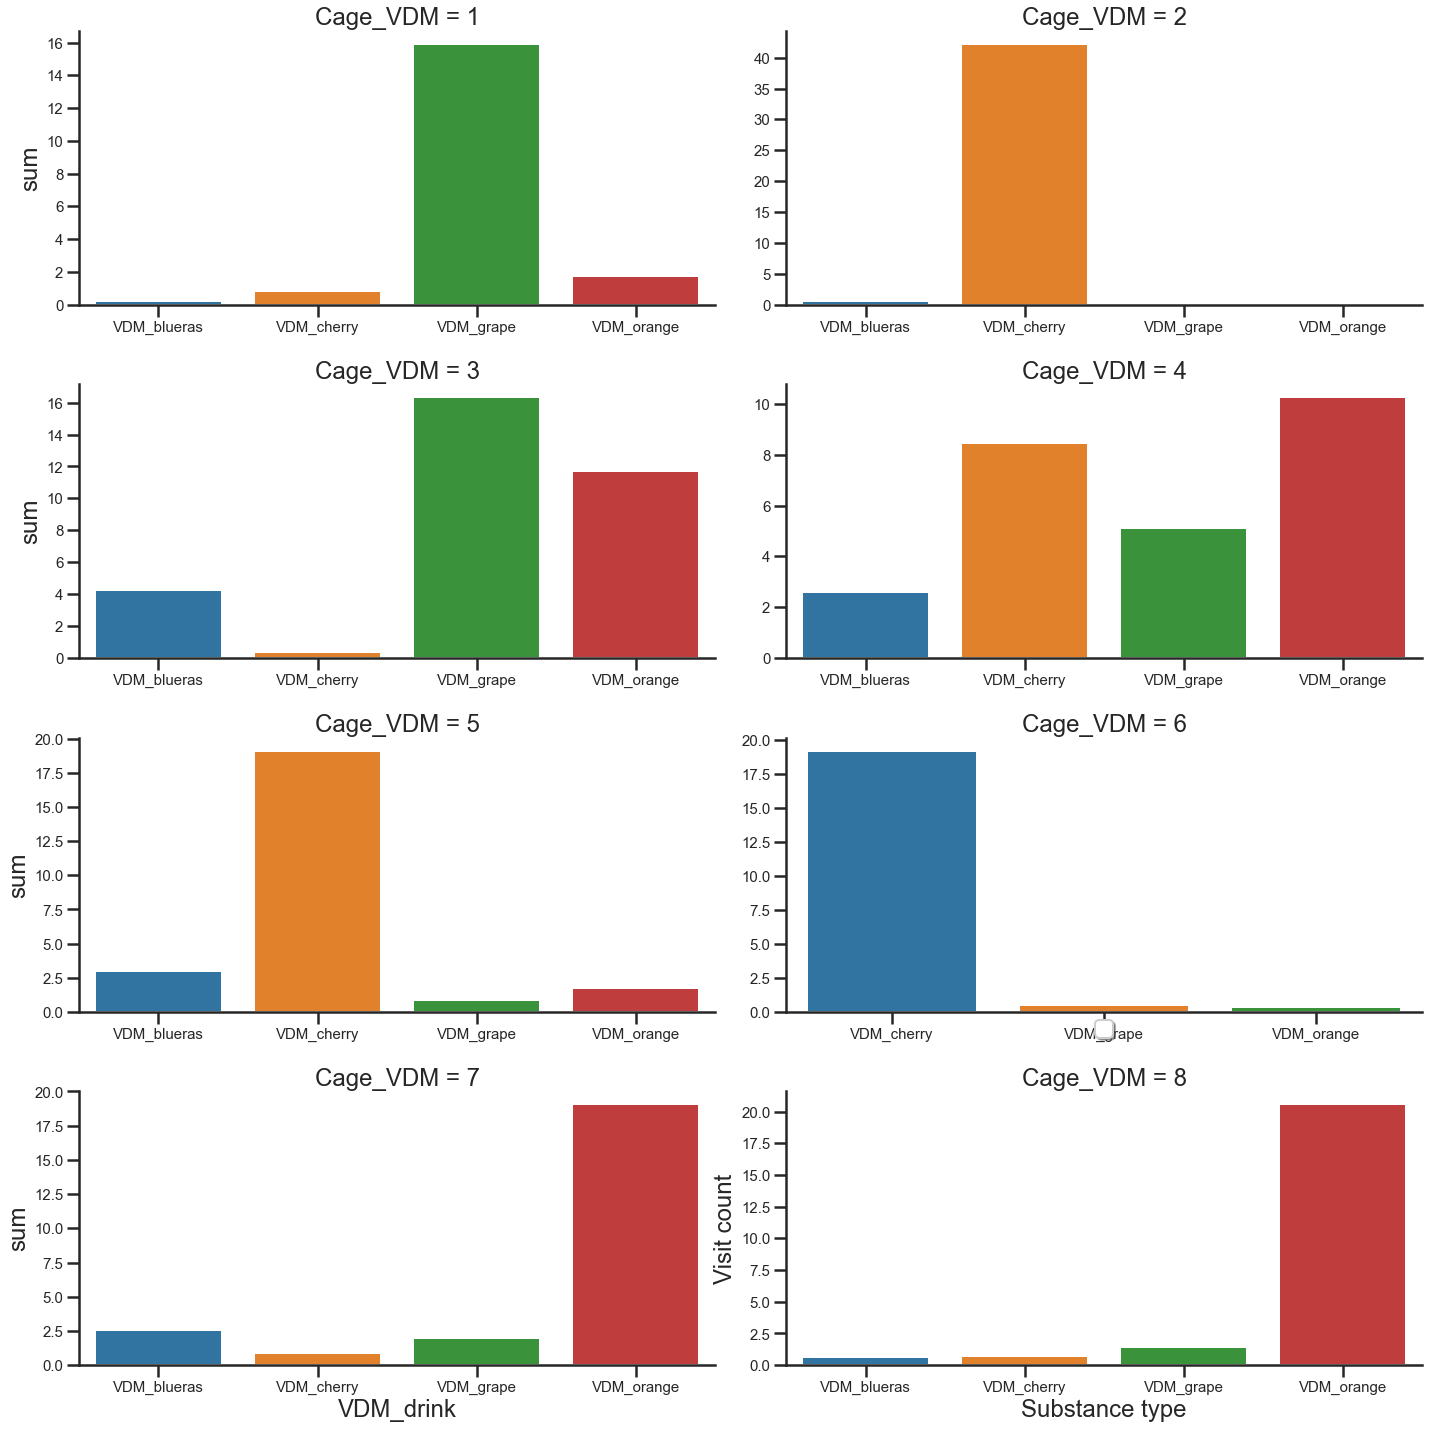

In [41]:
data_int = data_VDM_tidy_intake.groupby(['Cage_VDM', 'VDM_drink'])['value'].sum().reset_index(name='sum')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="VDM_drink", y='sum', kind='bar', height=5, aspect=2, 
            col='Cage_VDM', col_wrap=2, sharey=False, sharex=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### Filter RFID data by VDM times

In [42]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['VDM_drink', 'VDM_datetime']).reset_index(drop=True)

print(data_VDM_tidy_intake.groupby('Cage_VDM')['VDM_drink'].value_counts())
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

Cage_VDM  VDM_drink  
1         VDM_grape      747 
          VDM_orange     78  
          VDM_cherry     39  
          VDM_blueras    11  
2         VDM_cherry     2003
          VDM_blueras    26  
          VDM_orange     10  
          VDM_grape      2   
3         VDM_grape      591 
          VDM_orange     462 
          VDM_blueras    118 
          VDM_cherry     17  
4         VDM_orange     488 
          VDM_cherry     336 
          VDM_grape      236 
          VDM_blueras    117 
5         VDM_cherry     677 
          VDM_blueras    90  
          VDM_orange     60  
          VDM_grape      41  
6         VDM_cherry     905 
          VDM_grape      22  
          VDM_orange     16  
7         VDM_orange     811 
          VDM_blueras    121 
          VDM_grape      77  
          VDM_cherry     14  
8         VDM_orange     831 
          VDM_grape      66  
          VDM_cherry     33  
          VDM_blueras    29  
Name: VDM_drink, dtype: int64
(9074, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
0,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:19,drink_2,0.021,2021-12-20 13:04:19,1.640005e+09,2021-12-20,20,13:04:19,13,4,19,light,VDM_blueras
1,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:23,drink_2,0.021,2021-12-20 13:04:23,1.640005e+09,2021-12-20,20,13:04:23,13,4,23,light,VDM_blueras
2,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:31,drink_2,0.021,2021-12-20 13:04:31,1.640005e+09,2021-12-20,20,13:04:31,13,4,31,light,VDM_blueras
3,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:09:55,drink_2,0.042,2021-12-20 13:09:55,1.640006e+09,2021-12-20,20,13:09:55,13,9,55,light,VDM_blueras
4,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:10:03,drink_2,0.042,2021-12-20 13:10:03,1.640006e+09,2021-12-20,20,13:10:03,13,10,3,light,VDM_blueras


In [43]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
print(data_RFID_final['unitLabel_drink'].value_counts())
data_RFID_final.head()

orange      32561
blue_ras    26622
grape       26530
cherry      23861
Name: unitLabel_drink, dtype: int64


,Round,Build,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
0,flavor,four_eight,na,5,041AC00422,1633.0,na,female,3,blue_ras,Spyder2.17,9.662,light,light_day1,1,12,57,13,2021-12-20 12:57:13.701974400,2021-12-20 12:57:23.363974400,12:57:13,12:57:23,777,46633,12,777,46573,Idspyder-21.12.20.csv,24.7,NaN,NaN,NaN
1,flavor,four_eight,na,6,041AC006F3,1630.0,na,female,3,blue_ras,Spyder2.21,8.673,light,light_day1,1,12,57,13,2021-12-20 12:57:13.701974400,2021-12-20 12:57:22.374974400,12:57:13,12:57:22,777,46633,12,777,46573,Idspyder-21.12.20.csv,23.1,NaN,NaN,NaN
2,flavor,four_eight,na,1,041AC00425,1612.0,na,male,3,blue_ras,Spyder1.1,28.587,light,light_day1,1,12,57,18,2021-12-20 12:57:18.530956800,2021-12-20 12:57:47.117956800,12:57:18,12:57:47,777,46638,12,777,46578,Idspyder-21.12.20.csv,32.9,NaN,NaN,NaN
3,flavor,four_eight,na,5,041AC00422,1633.0,na,female,3,blue_ras,Spyder2.17,2.421,light,light_day1,1,12,57,27,2021-12-20 12:57:27.490982400,2021-12-20 12:57:29.911982400,12:57:27,12:57:29,777,46647,12,777,46587,Idspyder-21.12.20.csv,24.7,NaN,NaN,NaN
4,flavor,four_eight,na,5,041AC00422,1633.0,na,female,3,blue_ras,Spyder2.17,3.098,light,light_day1,1,12,57,30,2021-12-20 12:57:30.953030400,2021-12-20 12:57:34.051030400,12:57:30,12:57:34,777,46650,12,777,46590,Idspyder-21.12.20.csv,24.7,NaN,NaN,NaN


In [ ]:
VDM_RFID_mapping = {'VDM_cherry': 'cherry',
                    'VDM_orange': 'orange',
                    'VDM_blueras': 'blue_ras',
                    'VDM_grape': 'grape'}

VDM_RFID_mapping = {'VDM_water': 'water',
                    'VDM_orange': 'orange',
                    'VDM_grange': 'grange',
                    'VDM_grape': 'grape'}

In [44]:
data_comb = data_VDM_tidy_intake

VDM_RFID_mapping = {'VDM_cherry': 'cherry',
                    'VDM_orange': 'orange',
                    'VDM_blueras': 'blue_ras',
                    'VDM_grape': 'grape'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []

ld_cycle = []
ld_day = []


for index, row in data_comb.iterrows():
    if index%1000 == 0:
        print(index)
        
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = data_RFID_final[(data_RFID_final['Cage'] == int(row['Cage_VDM'])) & #match cage
                               (data_RFID_final['unitLabel_drink'] == VDM_RFID_mapping[row['VDM_drink']]) & #match tube
                               (data_RFID_final['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel_drink'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])

        ld_cycle.append(int_assign['ld_cycle'])
        ld_day.append(int_assign['ld_day'])
        
    except:
        print(index, 'pre', row['Cage_VDM'])
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)

        ld_cycle.append(np.nan)
        ld_day.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre

data_comb['ld_cycle'] = ld_cycle
data_comb['ld_day'] = ld_day


print(data_comb.shape)
data_comb.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
(9074, 22)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day
0,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:19,drink_2,0.021,2021-12-20 13:04:19,1.640005e+09,2021-12-20,20,13:04:19,13,4,19,light,VDM_blueras,16.540,041AC02E92,blue_ras,2021-12-20 13:04:08.496019199,2021-12-20 13:04:25.036019199,light,light_day1
1,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:23,drink_2,0.021,2021-12-20 13:04:23,1.640005e+09,2021-12-20,20,13:04:23,13,4,23,light,VDM_blueras,16.540,041AC02E92,blue_ras,2021-12-20 13:04:08.496019199,2021-12-20 13:04:25.036019199,light,light_day1
2,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:31,drink_2,0.021,2021-12-20 13:04:31,1.640005e+09,2021-12-20,20,13:04:31,13,4,31,light,VDM_blueras,11.075,041AC02E92,blue_ras,2021-12-20 13:04:26.868028800,2021-12-20 13:04:37.943028800,light,light_day1
3,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:09:55,drink_2,0.042,2021-12-20 13:09:55,1.640006e+09,2021-12-20,20,13:09:55,13,9,55,light,VDM_blueras,87.455,041ABFF7C1,blue_ras,2021-12-20 13:09:49.194979200,2021-12-20 13:11:16.649979200,light,light_day1
4,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:10:03,drink_2,0.042,2021-12-20 13:10:03,1.640006e+09,2021-12-20,20,13:10:03,13,10,3,light,VDM_blueras,87.455,041ABFF7C1,blue_ras,2021-12-20 13:09:49.194979200,2021-12-20 13:11:16.649979200,light,light_day1


In [45]:
data_comb.isna().sum()

VDM_file                   0
Cage_VDM                   0
VDM_Time                   0
variable                   0
value                      0
VDM_datetime               0
VDM_timestamp              0
VDM_date                   0
VDM_day                    0
VDM_time                   0
VDM_hour                   0
VDM_min                    0
VDM_second                 0
ld_seg                     0
VDM_drink                  0
RFID_eventDuration         0
RFID_assign_id_pre         0
RFID_assign_var_pre        0
RFID_datetime_start_pre    0
RFID_datetime_end_pre      0
ld_cycle                   0
ld_day                     0
dtype: int64

In [46]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb['VDM_RFID_timediff_bool'] = ['same' if x==0 else 'diff' for x in data_comb['VDM_RFID_timediff']]

data_comb.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:19,drink_2,0.021,2021-12-20 13:04:19,1.640005e+09,2021-12-20,20,13:04:19,13,4,19,light,VDM_blueras,16.540,041AC02E92,blue_ras,2021-12-20 13:04:08.496019199,2021-12-20 13:04:25.036019199,light,light_day1,0.0,same
1,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:23,drink_2,0.021,2021-12-20 13:04:23,1.640005e+09,2021-12-20,20,13:04:23,13,4,23,light,VDM_blueras,16.540,041AC02E92,blue_ras,2021-12-20 13:04:08.496019199,2021-12-20 13:04:25.036019199,light,light_day1,0.0,same
2,br.c.g.o_switchfm_211220.csv,2,12/20/21 13:04:31,drink_2,0.021,2021-12-20 13:04:31,1.640005e+09,2021-12-20,20,13:04:31,13,4,31,light,VDM_blueras,11.075,041AC02E92,blue_ras,2021-12-20 13:04:26.868028800,2021-12-20 13:04:37.943028800,light,light_day1,0.0,same
3,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:09:55,drink_2,0.042,2021-12-20 13:09:55,1.640006e+09,2021-12-20,20,13:09:55,13,9,55,light,VDM_blueras,87.455,041ABFF7C1,blue_ras,2021-12-20 13:09:49.194979200,2021-12-20 13:11:16.649979200,light,light_day1,0.0,same
4,br.c.g.o_switchfm_211220.csv,5,12/20/21 13:10:03,drink_2,0.042,2021-12-20 13:10:03,1.640006e+09,2021-12-20,20,13:10:03,13,10,3,light,VDM_blueras,87.455,041ABFF7C1,blue_ras,2021-12-20 13:09:49.194979200,2021-12-20 13:11:16.649979200,light,light_day1,0.0,same


In [47]:
data_comb.groupby(['VDM_drink', 'Cage_VDM'])['VDM_RFID_timediff_bool'].value_counts()

VDM_drink    Cage_VDM  VDM_RFID_timediff_bool
VDM_blueras  1         diff                      8   
                       same                      3   
             2         same                      16  
                       diff                      10  
             3         same                      108 
                       diff                      10  
             4         same                      95  
                       diff                      22  
             5         same                      72  
                       diff                      18  
             7         same                      87  
                       diff                      34  
             8         same                      18  
                       diff                      11  
VDM_cherry   1         diff                      26  
                       same                      13  
             2         same                      1912
                       diff         

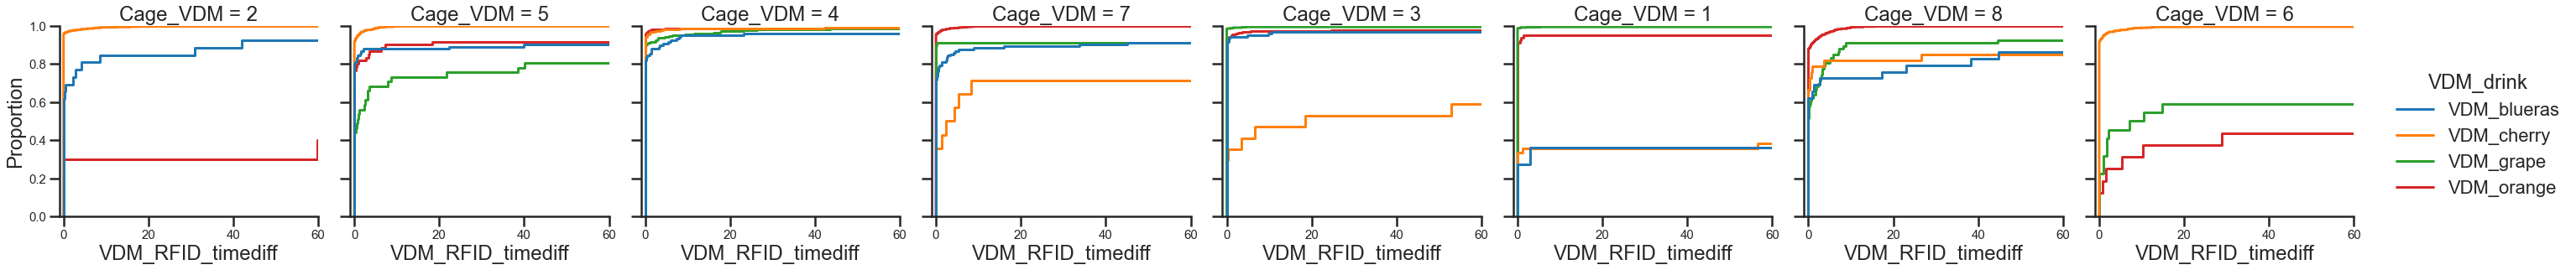

In [48]:
sns.displot(data=data_comb, x="VDM_RFID_timediff", kind="ecdf", hue='VDM_drink', col='Cage_VDM')

plt.xlim(-1, 60)
plt.show()

#### Add metadata

In [49]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(9074, 40)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,125,br.c.g.o_switchfm_211220.csv,1,12/21/21 00:11:55,drink_2,0.021,2021-12-21 00:11:55,1.640046e+09,2021-12-21,21,00:11:55,0,11,55,dark_am,VDM_blueras,0.909,041AC00425,blue_ras,2021-12-20 23:58:57.471024000,2021-12-20 23:58:58.380024000,dark,dark_night1,776.619976,diff
1,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,656,br.c.g.o_switchfm_211220.csv,1,12/20/21 20:28:43,drink_1,0.021,2021-12-20 20:28:43,1.640032e+09,2021-12-20,20,20:28:43,20,28,43,dark_pm,VDM_cherry,1.422,041AC00425,cherry,2021-12-20 20:14:35.651011200,2021-12-20 20:14:37.073011200,dark,dark_night1,845.926988,diff
2,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,954,br.c.g.o_switchfm_211220.csv,1,12/20/21 22:28:29,drink_1,0.021,2021-12-20 22:28:29,1.640039e+09,2021-12-20,20,22:28:29,22,28,29,dark_pm,VDM_cherry,1.010,041AC00425,cherry,2021-12-20 22:01:19.185974400,2021-12-20 22:01:20.195974400,dark,dark_night1,1628.804025,diff
3,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,1155,br.c.g.o_switchfm_211220.csv,1,12/21/21 00:27:45,drink_1,0.021,2021-12-21 00:27:45,1.640046e+09,2021-12-21,21,00:27:45,0,27,45,dark_am,VDM_cherry,0.075,041AC00425,cherry,2021-12-20 23:58:51.406003200,2021-12-20 23:58:51.481003200,dark,dark_night1,1733.518996,diff
4,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,1264,br.c.g.o_switchfm_211220.csv,1,12/21/21 02:29:56,drink_1,0.021,2021-12-21 02:29:56,1.640054e+09,2021-12-21,21,02:29:56,2,29,56,dark_am,VDM_cherry,7.225,041AC00425,cherry,2021-12-21 02:20:46.887964800,2021-12-21 02:20:54.112964800,dark,dark_night1,541.887035,diff


#### Add day, hour, and min counts

In [50]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].sort_values().unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['day_count'] = data_comb['VDM_date'].map(dat_map)

#column of running min and second count within each day
data_comb['min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['sec_count'] = (data_comb['min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count across all days
data_comb['hour_count_running'] = (data_comb['day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['min_count_running'] = (data_comb['hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['sec_count_running'] = (data_comb['min_count_running']*60) + data_comb['VDM_second'] - 60

#ld
#data_comb['LD'] = [x.split('_')[0] for x in data_comb['ld']]

print(data_comb.shape)
data_comb.head()

(9074, 46)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,125,br.c.g.o_switchfm_211220.csv,1,12/21/21 00:11:55,drink_2,0.021,2021-12-21 00:11:55,1.640046e+09,2021-12-21,21,00:11:55,0,11,55,dark_am,VDM_blueras,0.909,041AC00425,blue_ras,2021-12-20 23:58:57.471024000,2021-12-20 23:58:58.380024000,dark,dark_night1,776.619976,diff,2,11,715,24,1451,87055
1,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,656,br.c.g.o_switchfm_211220.csv,1,12/20/21 20:28:43,drink_1,0.021,2021-12-20 20:28:43,1.640032e+09,2021-12-20,20,20:28:43,20,28,43,dark_pm,VDM_cherry,1.422,041AC00425,cherry,2021-12-20 20:14:35.651011200,2021-12-20 20:14:37.073011200,dark,dark_night1,845.926988,diff,1,1228,73723,20,1228,73663
2,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,954,br.c.g.o_switchfm_211220.csv,1,12/20/21 22:28:29,drink_1,0.021,2021-12-20 22:28:29,1.640039e+09,2021-12-20,20,22:28:29,22,28,29,dark_pm,VDM_cherry,1.010,041AC00425,cherry,2021-12-20 22:01:19.185974400,2021-12-20 22:01:20.195974400,dark,dark_night1,1628.804025,diff,1,1348,80909,22,1348,80849
3,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,1155,br.c.g.o_switchfm_211220.csv,1,12/21/21 00:27:45,drink_1,0.021,2021-12-21 00:27:45,1.640046e+09,2021-12-21,21,00:27:45,0,27,45,dark_am,VDM_cherry,0.075,041AC00425,cherry,2021-12-20 23:58:51.406003200,2021-12-20 23:58:51.481003200,dark,dark_night1,1733.518996,diff,2,27,1665,24,1467,88005
4,flavor,four_eight,21.12.20,na,1,041AC00425,1612.0,466.0,na,male,3,32.9,NaN,NaN,NaN,1264,br.c.g.o_switchfm_211220.csv,1,12/21/21 02:29:56,drink_1,0.021,2021-12-21 02:29:56,1.640054e+09,2021-12-21,21,02:29:56,2,29,56,dark_am,VDM_cherry,7.225,041AC00425,cherry,2021-12-21 02:20:46.887964800,2021-12-21 02:20:54.112964800,dark,dark_night1,541.887035,diff,2,149,8996,26,1589,95336


In [51]:
data_comb['substance'] = [x.split('_')[-1] for x in data_comb['VDM_drink']]

In [52]:
data_comb.to_csv('flavor_211220.csv')